# Generic Functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.signal import butter, savgol_filter
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import keras.layers as L
import tensorflow as tf
from sklearn import linear_model
from keras import callbacks
import keras.models as M
import keras.optimizers as O

%matplotlib inline
np.random.seed(103)

Using TensorFlow backend.


In [2]:
def create_time_stepped_data(df, time_steps,num_features):
    d = []
    for i in range(time_steps):
        d.append(df.shift(-i).values[:-time_steps].reshape(-1,num_features+1))
    return np.transpose(np.array(d),(1,0,2))

In [3]:
def create_formatted_data(df, time_steps, num_features):
    assert (time_steps%2 !=0), "Time steps should be odd!"
    d = create_time_stepped_data(df, time_steps, num_features)
    
    past = d[:,:int(time_steps/2),:]
    #fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
    fut = np.flip(d[:,:int(time_steps/2),:],1)
    y = d[:,int(time_steps/2),-1]
    if(num_features == 0):
        cur = np.zeros((d.shape[0],1,256))
    else:
        cur = d[:,int(time_steps/2),:-1]
        cur = np.dstack((cur.reshape(-1,1,num_features+1),np.zeros(shape=(d.shape[0],1,256-num_features))))
    return past,cur,fut,y

In [4]:
def train_test_split(past,fut,cur,y):
    train_split = int(0.8*y.shape[0])
    return past[:train_split], past[train_split:], fut[:train_split], np.zeros_like(past[train_split:]), cur[:train_split], cur[train_split:], y[:train_split], y[train_split:]

In [5]:
def model_build1(input_shape1, input_shape2, loss = 1):
    
    past_inp = L.Input(shape=(input_shape1))
    fut_inp = L.Input(shape=(input_shape2))
    
    cnn1 = L.Conv1D(filters=256,kernel_size=5)(past_inp)
    #cnn1 = L.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = L.Conv1D(filters=256,kernel_size=2)(cnn1)
    cnn1 = L.Dense(256)(cnn1)
    cnn1 = L.advanced_activations.LeakyReLU(0.2)(cnn1)
        
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(cnn1)
    x1 = L.Dense(516)(x1)
    x1 = L.Dropout(0.2)(x1)
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = L.Dense(516)(x1)
    x1 = L.Dropout(0.2)(x1)
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out1 = L.Dropout(0.2)(x1)
    lstm_out1 = L.Concatenate(axis=1)([cnn1,lstm_out1])
    
    cnn2 = L.Conv1D(filters=256,kernel_size=5)(fut_inp)
    cnn2 = L.Conv1D(filters=256,kernel_size=2)(cnn2)
    cnn2 = L.Dense(256)(cnn2)
    cnn2 = L.advanced_activations.LeakyReLU(0.2)(cnn2)
        
    x2 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(cnn2)
    x2 = L.Dense(516)(x2)
    x2 = L.Dropout(0.2)(x2)
    x2 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x2)
    x2 = L.Dense(516)(x2)
    x2 = L.Dropout(0.2)(x2)
    x2 = L.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x2)
    x2 = L.Dense(256)(x2)
    x2 = L.advanced_activations.LeakyReLU(0.2)(x2)
    lstm_out2 = L.Dropout(0.2)(x2)
    lstm_out2 = L.Concatenate(axis=1)([cnn2,lstm_out2])
    
    x = L.Average()([lstm_out1,lstm_out2])
    x = L.Flatten()(x)
    
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1024)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1)(x)
    main_out = L.advanced_activations.LeakyReLU(0.2)(x)
    
    model = M.Model(inputs=[past_inp, fut_inp], outputs=[main_out], name='CLDNN') 
    model.summary()
    if(loss == 1):
        model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae'])
    else:
        model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model    

In [6]:
def model_build(input_shape1, input_shape2, cur_input_shape, loss=1):
    
    past_inp = L.Input(shape=(input_shape1))
    fut_inp = L.Input(shape=(input_shape2))
    cur_inp = L.Input(shape=(cur_input_shape))
    
    cnn1 = L.Conv1D(filters=256,kernel_size=5)(past_inp)
    cnn1 = L.Conv1D(filters=256,kernel_size=3)(cnn1)
    cnn1 = L.Dense(256)(cnn1)
    cnn1 = L.advanced_activations.LeakyReLU(0.2)(cnn1)
    
    cnn2 = L.Conv1D(filters=256,kernel_size=5)(fut_inp)
    cnn2 = L.Conv1D(filters=256,kernel_size=3)(cnn2)
    cnn2 = L.Dense(256)(cnn2)
    cnn2 = L.advanced_activations.LeakyReLU(0.2)(cnn2)
    
    cnn_out = L.Concatenate(axis=1)([cnn1,cnn2])
    lstm_inp = L.Add()([cnn_out,cur_inp])
    
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.2, return_sequences=True)(lstm_inp)
    x1 = L.Dense(516)(x1)
    x1 = L.Dropout(0.3)(x1)
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.2, return_sequences=True)(x1)
    x1 = L.Dense(516)(x1)
    x1 = L.Dropout(0.3)(x1)
    x1 = L.LSTM(832, unroll=True, recurrent_dropout=0.2, return_sequences=True)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out = L.Dropout(0.3)(x1)
    
    x1 = L.Concatenate(axis=1)([lstm_out,cnn_out])
    x1 = L.Flatten()(x1)
    
    x1 = L.Dense(1024)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1024)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1024)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1024)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1024)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1024)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    main_out = L.Dense(1)(x1)
    model = M.Model(inputs=[past_inp,fut_inp,cur_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    if(loss == 1):
        model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae'])
    else:
        model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model

In [7]:
def linear_regression(model_pred, data):
    lin_model = linear_model.LinearRegression()
    split = int(0.7 * data.shape[0])
    training_data_x, training_data_y = model_pred[:split], data[:split]
    testing_data_x, testing_data_y = model_pred[split:], data[split:]
    lin_model.fit(training_data_x, training_data_y)
    lin_model_pred = lin_model.predict(testing_data_x)
    print("MAE %.4f\nR2 %.4f\nRMSE %.4f"%(mean_absolute_error(testing_data_y,lin_model_pred), r2_score(testing_data_y,lin_model_pred),np.sqrt(mean_squared_error(testing_data_y,lin_model_pred))))
    return lin_model

# Model + Linear Regression (entire future_train = 0)

## Airpassengers Data

In [54]:
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

data.index

ts = data['#Passengers'] 
ts.head(10)
df = pd.DataFrame(ts)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [55]:
past,cur,fut,y = create_formatted_data(df, 21, 0)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [61]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past[:100], fut[:100], cur[:100]], y[:100], epochs=50, batch_size=32, validation_data=([past[100:],fut[100:],cur[100:]],y[100:]))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 6, 256)       1536        input_34[0][0]                   
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 6, 256)       1536        input_35[0][0]                   
__________________________________________________________________________________________________
conv1d_41 

Train on 100 samples, validate on 23 samples
Epoch 1/50
100/100 [==============================] - 13s 125ms/step - loss: 41372.4961 - mean_absolute_error: 177.8223 - val_loss: 698050.5000 - val_mean_absolute_error: 818.8007
Epoch 2/50
100/100 [==============================] - 2s 15ms/step - loss: 130063.5719 - mean_absolute_error: 309.9915 - val_loss: 22040.3770 - val_mean_absolute_error: 130.8050
Epoch 3/50
100/100 [==============================] - 2s 15ms/step - loss: 12863.4369 - mean_absolute_error: 96.2608 - val_loss: 54367.7383 - val_mean_absolute_error: 220.6306
Epoch 4/50
100/100 [==============================] - 2s 15ms/step - loss: 15117.6534 - mean_absolute_error: 98.8391 - val_loss: 80152.8672 - val_mean_absolute_error: 273.6495
Epoch 5/50
100/100 [==============================] - 2s 15ms/step - loss: 20235.9672 - mean_absolute_error: 123.9214 - val_loss: 41955.0859 - val_mean_absolute_error: 177.7231
Epoch 6/50
100/100 [==============================] - 2s 15ms/step -

Epoch 48/50
100/100 [==============================] - 1s 15ms/step - loss: 643.6662 - mean_absolute_error: 20.5556 - val_loss: 1452.7136 - val_mean_absolute_error: 30.2990
Epoch 49/50
100/100 [==============================] - 2s 15ms/step - loss: 363.6378 - mean_absolute_error: 15.3707 - val_loss: 727.3198 - val_mean_absolute_error: 23.3853
Epoch 50/50
100/100 [==============================] - 1s 15ms/step - loss: 208.6107 - mean_absolute_error: 11.6798 - val_loss: 638.7813 - val_mean_absolute_error: 20.6112


In [ ]:
fut_train1 = np.zeros_like(fut_train)
pred = model1.predict([past_train, fut_train1, cur_train], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model1.predict([past_test, fut_test, cur_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
print(pred1.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred1))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model pred1ictions')
plt.legend()
plt.show()

In [ ]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Jena Weather data

In [10]:
data = pd.DataFrame(pd.read_csv("Jena_time_series_data.csv")['T (degC)'])[-2000:]
data.reset_index(drop=True,inplace=True)

In [11]:
time_steps = 21
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [12]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:], 1)
model1.fit([past_train, fut_train, cur_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

Train on 1583 samples, validate on 396 samples
Epoch 1/20
1583/1583 [==============================] - 26s 16ms/step - loss: 2.2744 - mean_absolute_error: 2.6721 - val_loss: 2.4274 - val_mean_absolute_error: 2.8308
Epoch 2/20
1583/1583 [==============================] - 21s 13ms/step - loss: 0.0780 - mean_absolute_error: 0.2987 - val_loss: 2.4902 - val_mean_absolute_error: 2.9166
Epoch 3/20
1583/1583 [==============================] - 22s 14ms/step - loss: 0.1250 - mean_absolute_error: 0.3722 - val_loss: 2.6074 - val_mean_absolute_error: 3.0383
Epoch 4/20
1583/1583 [==============================] - 22s 14ms/step - loss: 0.1184 - mean_absolute_error: 0.3752 - val_loss: 2.7223 - val_mean_absolute_error: 3.1558
Epoch 5/20
1583/1583 [==============================] - 23s 15ms/step - loss: 0.1071 - mean_absolute_error: 0.3696 - val_loss: 2.1609 - val_mean_absolute_error: 2.5878
Epoch 6/20
1583/1583 [==============================] - 23s 15ms/step - loss: 0.0908 - mean_absolute_error: 0.332

(396,) (396,)


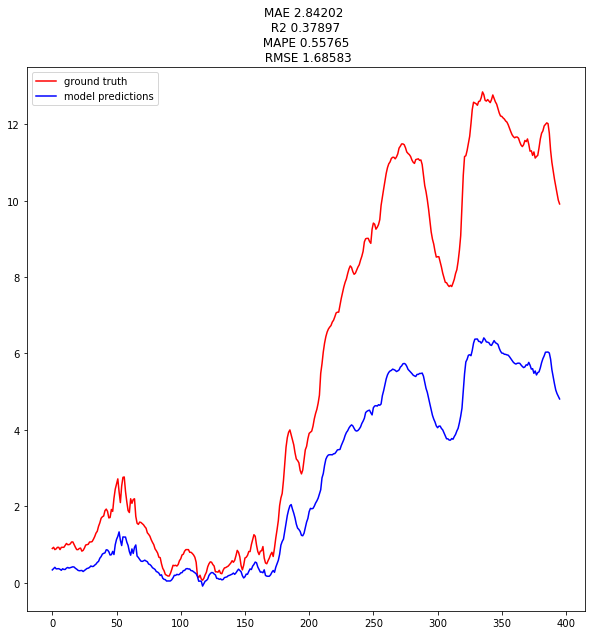

In [13]:
pred = model1.predict([past_test, fut_test, cur_test], batch_size=32).reshape((-1,))
test = y_test.reshape((-1,))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [14]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:], 1)
model1.fit([past_train, fut_train, cur_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,past_test,cur_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 6, 256)       1536        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 6, 256)       1536        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_14 

Train on 1583 samples, validate on 396 samples
Epoch 1/20
1583/1583 [==============================] - 28s 18ms/step - loss: 1.5078 - mean_absolute_error: 1.8772 - val_loss: 0.3154 - val_mean_absolute_error: 0.6405
Epoch 2/20
1583/1583 [==============================] - 21s 13ms/step - loss: 0.0878 - mean_absolute_error: 0.3290 - val_loss: 0.3056 - val_mean_absolute_error: 0.6240
Epoch 3/20
1583/1583 [==============================] - 21s 13ms/step - loss: 0.1027 - mean_absolute_error: 0.3492 - val_loss: 0.2132 - val_mean_absolute_error: 0.5042
Epoch 4/20
1583/1583 [==============================] - 21s 13ms/step - loss: 0.0361 - mean_absolute_error: 0.2011 - val_loss: 0.0998 - val_mean_absolute_error: 0.3391
Epoch 5/20
1583/1583 [==============================] - 20s 12ms/step - loss: 0.0546 - mean_absolute_error: 0.2222 - val_loss: 0.0647 - val_mean_absolute_error: 0.2609
Epoch 6/20
1583/1583 [==============================] - 20s 13ms/step - loss: 0.0538 - mean_absolute_error: 0.220

(396,) (396,)


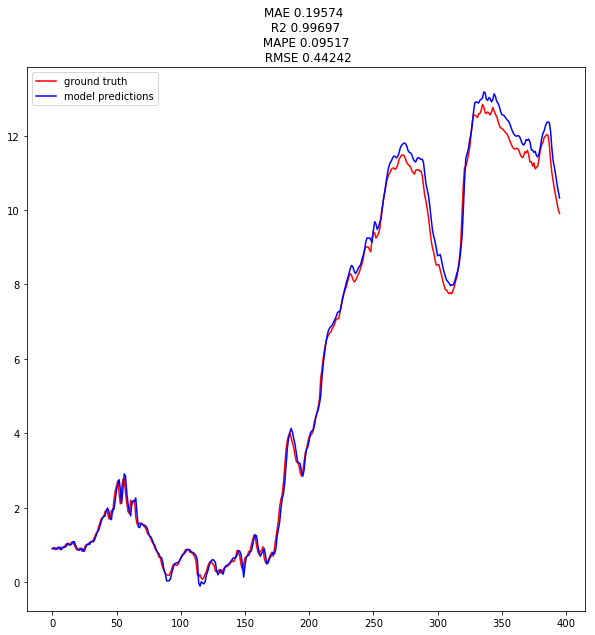

In [15]:
pred = model1.predict([past_test, past_test, cur_test], batch_size=32).reshape((-1,))
test = y_test.reshape((-1,))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [11]:
model1 = model_build1(past.shape[1:], fut.shape[1:])
model1.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

Train on 1583 samples, validate on 396 samples
Epoch 1/20
1583/1583 [==============================] - 39s 25ms/step - loss: 2.7168 - mean_absolute_error: 3.1081 - val_loss: 0.5015 - val_mean_absolute_error: 0.8786
Epoch 2/20
1583/1583 [==============================] - 27s 17ms/step - loss: 0.1186 - mean_absolute_error: 0.3667 - val_loss: 0.0573 - val_mean_absolute_error: 0.2549
Epoch 3/20
1583/1583 [==============================] - 28s 17ms/step - loss: 0.0652 - mean_absolute_error: 0.2694 - val_loss: 0.0364 - val_mean_absolute_error: 0.1991
Epoch 4/20
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2449 - mean_absolute_error: 0.5593 - val_loss: 0.1732 - val_mean_absolute_error: 0.4797
Epoch 5/20
1583/1583 [==============================] - 28s 18ms/step - loss: 0.0781 - mean_absolute_error: 0.3047 - val_loss: 0.0454 - val_mean_absolute_error: 0.2315
Epoch 6/20
1583/1583 [==============================] - 29s 18ms/step - loss: 0.0350 - mean_absolute_error: 0.195

(396,) (396,)


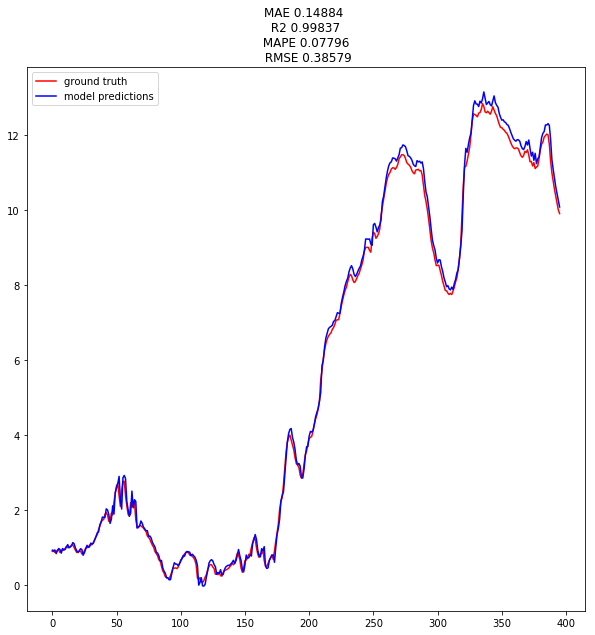

In [12]:
pred = model1.predict([past_test, fut_test], batch_size=32).reshape((-1,))
test = y_test.reshape((-1,))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [14]:
model1 = model_build1(past.shape[1:], fut.shape[1:])
model1.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,past_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 256)       1536        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       1536        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

Train on 1583 samples, validate on 396 samples
Epoch 1/20
1583/1583 [==============================] - 41s 26ms/step - loss: 1.6416 - mean_absolute_error: 2.0091 - val_loss: 1.1021 - val_mean_absolute_error: 1.4998
Epoch 2/20
1583/1583 [==============================] - 30s 19ms/step - loss: 0.3278 - mean_absolute_error: 0.6739 - val_loss: 0.2625 - val_mean_absolute_error: 0.5790
Epoch 3/20
1583/1583 [==============================] - 30s 19ms/step - loss: 0.0631 - mean_absolute_error: 0.2617 - val_loss: 0.1931 - val_mean_absolute_error: 0.4790
Epoch 4/20
1583/1583 [==============================] - 30s 19ms/step - loss: 0.0375 - mean_absolute_error: 0.2009 - val_loss: 0.3120 - val_mean_absolute_error: 0.6324
Epoch 5/20
1583/1583 [==============================] - 44s 28ms/step - loss: 0.0304 - mean_absolute_error: 0.1859 - val_loss: 0.1441 - val_mean_absolute_error: 0.4082
Epoch 6/20
1583/1583 [==============================] - 46s 29ms/step - loss: 0.0574 - mean_absolute_error: 0.263

(396,) (396,)


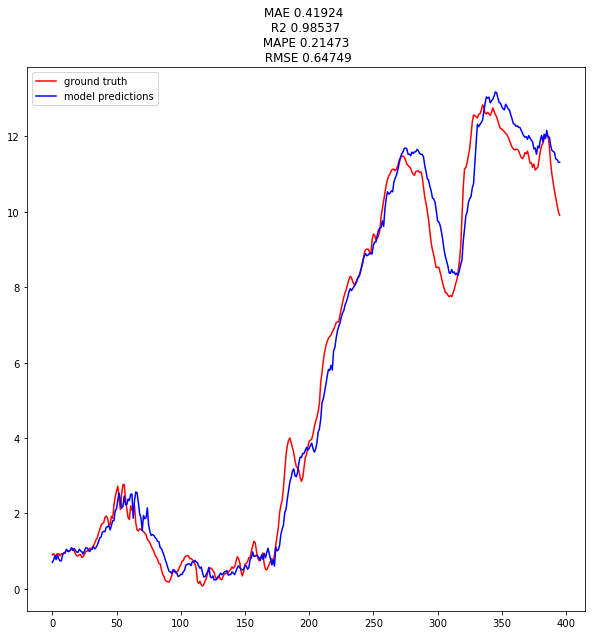

In [15]:
pred = model1.predict([past_test, past_test], batch_size=32).reshape((-1,))
test = y_test.reshape((-1,))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [10]:
fut_train1 = np.zeros_like(fut_train)
pred = model1.predict([past_train, fut_train1, cur_train], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model1.predict([past_test, fut_test, cur_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.2094
R2 0.9806
RMSE 0.2713


In [13]:
lin_model.coef_

array([ 2.21173453], dtype=float32)

(396, 1) (396,)


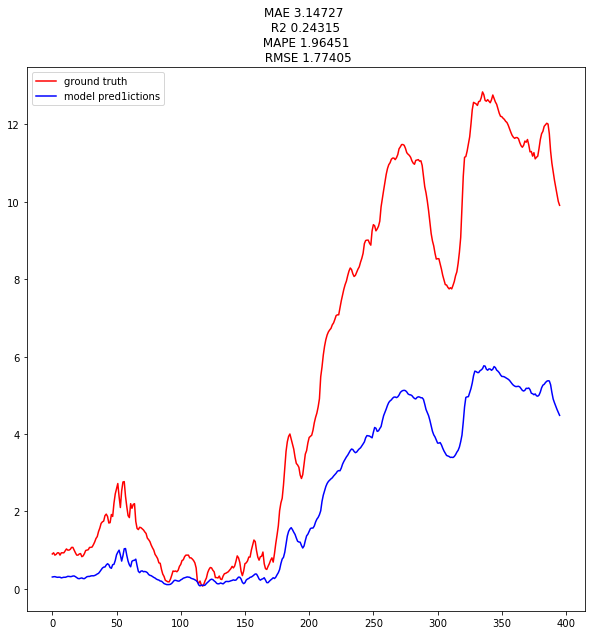

In [11]:
print(pred1.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred1))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model pred1ictions')
plt.legend()
plt.show()

(396,) (396,)


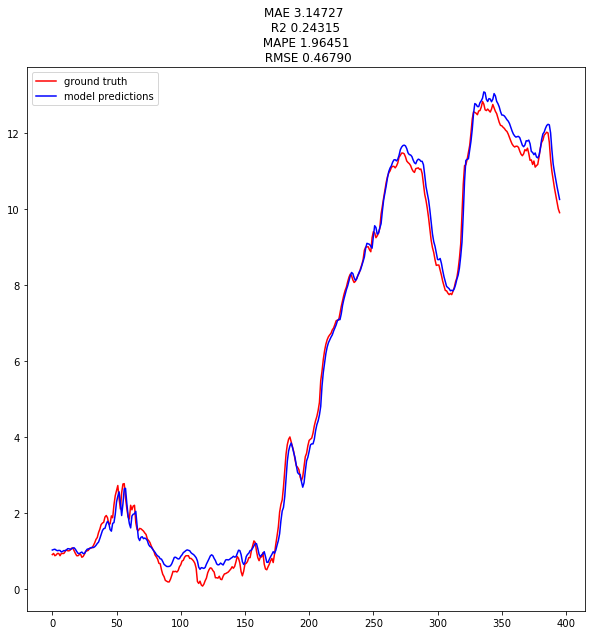

In [12]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## SPI DATA

In [3]:
data = pd.DataFrame(pd.read_csv("../notNiteeshData.csv")['ES_POPCORN SMALL'])
print (data.shape)
data = data[data[data.columns[0]]!=0]
data = data[data[data.columns[0]]<=600]
print (data.shape)

(991, 1)
(899, 1)


In [27]:
time_steps = 21
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [30]:
past_test = past_test * 2

In [31]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past_train, fut_train, cur_train], y_train, epochs=100, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 6, 256)       1536        input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 6, 256)       1536        input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_18 

Train on 702 samples, validate on 176 samples
Epoch 1/100
702/702 [==============================] - 16s 23ms/step - loss: 134782.3756 - mean_absolute_error: 316.4628 - val_loss: 15729.7859 - val_mean_absolute_error: 92.8129
Epoch 2/100
702/702 [==============================] - 9s 13ms/step - loss: 16127.6805 - mean_absolute_error: 101.9169 - val_loss: 11269.0921 - val_mean_absolute_error: 89.6074
Epoch 3/100
702/702 [==============================] - 9s 13ms/step - loss: 11112.9389 - mean_absolute_error: 84.1481 - val_loss: 9176.8703 - val_mean_absolute_error: 76.3485
Epoch 4/100
702/702 [==============================] - 9s 13ms/step - loss: 7238.4480 - mean_absolute_error: 66.0142 - val_loss: 7596.0885 - val_mean_absolute_error: 65.5825
Epoch 5/100
702/702 [==============================] - 9s 13ms/step - loss: 7033.6604 - mean_absolute_error: 64.9906 - val_loss: 7152.4790 - val_mean_absolute_error: 62.9926
Epoch 6/100
702/702 [==============================] - 9s 13ms/step - loss:

Epoch 94/100
702/702 [==============================] - 9s 13ms/step - loss: 1328.7678 - mean_absolute_error: 28.4844 - val_loss: 8161.9048 - val_mean_absolute_error: 65.8184
Epoch 95/100
702/702 [==============================] - 9s 13ms/step - loss: 905.4103 - mean_absolute_error: 23.6914 - val_loss: 10539.4260 - val_mean_absolute_error: 79.4296
Epoch 96/100
702/702 [==============================] - 9s 13ms/step - loss: 887.4952 - mean_absolute_error: 23.1297 - val_loss: 9490.0815 - val_mean_absolute_error: 76.6375
Epoch 97/100
702/702 [==============================] - 9s 13ms/step - loss: 1266.1657 - mean_absolute_error: 28.0255 - val_loss: 9197.3345 - val_mean_absolute_error: 76.0313
Epoch 98/100
702/702 [==============================] - 9s 13ms/step - loss: 1646.6245 - mean_absolute_error: 32.0228 - val_loss: 12345.6507 - val_mean_absolute_error: 82.4042
Epoch 99/100
702/702 [==============================] - 9s 13ms/step - loss: 1154.4866 - mean_absolute_error: 26.4700 - val_l

In [ ]:
fut_train1 = np.zeros_like(fut_train)
pred = model1.predict([past_train, fut_train1, cur_train], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model1.predict([past_test, fut_test, cur_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [13]:
lin_model.coef_

array([ 2.21173453], dtype=float32)

In [ ]:
print(pred1.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred1))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model pred1ictions')
plt.legend()
plt.show()

In [ ]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## ZURICH MONTHLY SUNSPOT DATA

In [47]:
data = pd.DataFrame(pd.read_csv("monthly-sunspot-number-zurich-17.csv"))
data = data[data.columns[1]]

In [48]:
time_steps = 21
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [9]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past_train, fut_train, cur_train], y_train, epochs=50, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 13, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 9, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 9, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

Train on 2234 samples, validate on 559 samples
Epoch 1/50
2234/2234 [==============================] - 48s 22ms/step - loss: 7478.5547 - mean_absolute_error: 26.1444 - val_loss: 1446.9892 - val_mean_absolute_error: 28.0587
Epoch 2/50
2234/2234 [==============================] - 41s 18ms/step - loss: 313.0561 - mean_absolute_error: 12.2469 - val_loss: 2513.4439 - val_mean_absolute_error: 38.3794
Epoch 3/50
2234/2234 [==============================] - 41s 18ms/step - loss: 236.0575 - mean_absolute_error: 10.7730 - val_loss: 2583.4922 - val_mean_absolute_error: 39.3973
Epoch 4/50
2234/2234 [==============================] - 41s 18ms/step - loss: 310.0701 - mean_absolute_error: 12.0095 - val_loss: 6175.9038 - val_mean_absolute_error: 63.6134
Epoch 5/50
2234/2234 [==============================] - 41s 18ms/step - loss: 333.1597 - mean_absolute_error: 12.8077 - val_loss: 2725.2628 - val_mean_absolute_error: 40.4729
Epoch 6/50
2234/2234 [==============================] - 41s 18ms/step - loss:

In [10]:
fut_train1 = np.zeros_like(fut_train)
pred = model1.predict([past_train, fut_train1, cur_train], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model1.predict([past_test, fut_test, cur_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 10.4830
R2 0.7836
RMSE 13.6966


In [11]:
lin_model.coef_

array([ 2.10465455], dtype=float32)

(559, 1) (559,)


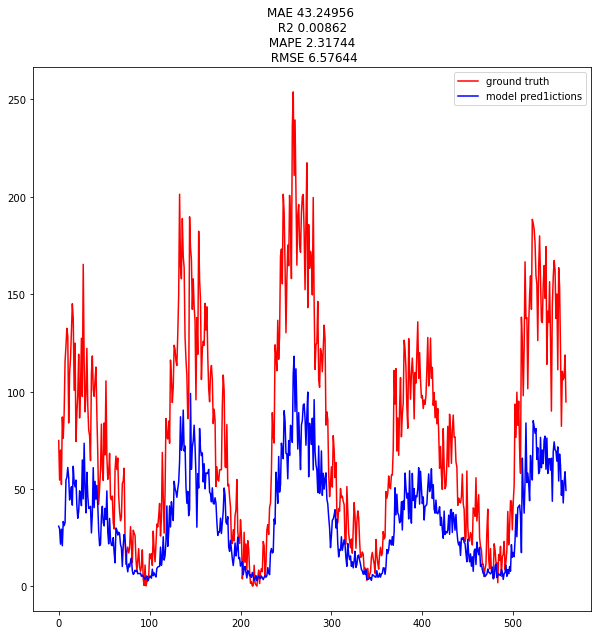

In [12]:
print(pred1.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred1))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model pred1ictions')
plt.legend()
plt.show()

(559,) (559,)


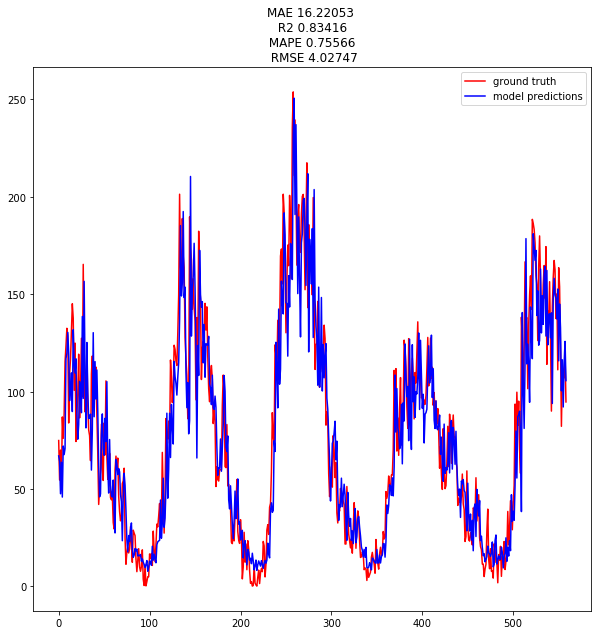

In [16]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [49]:
model1 = model_build1(past.shape[1:], fut.shape[1:])
model1.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 6, 256)       1536        input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 6, 256)       1536        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_22 

Train on 2239 samples, validate on 560 samples
Epoch 1/20
2239/2239 [==============================] - 51s 23ms/step - loss: 16.7423 - mean_absolute_error: 17.2288 - val_loss: 41.4957 - val_mean_absolute_error: 41.9925
Epoch 2/20
2239/2239 [==============================] - 38s 17ms/step - loss: 12.1416 - mean_absolute_error: 12.6276 - val_loss: 47.7107 - val_mean_absolute_error: 48.2084
Epoch 3/20
2239/2239 [==============================] - 38s 17ms/step - loss: 12.5664 - mean_absolute_error: 13.0534 - val_loss: 42.5341 - val_mean_absolute_error: 43.0308
Epoch 4/20
2239/2239 [==============================] - 38s 17ms/step - loss: 11.9275 - mean_absolute_error: 12.4115 - val_loss: 31.9717 - val_mean_absolute_error: 32.4645
Epoch 5/20
2239/2239 [==============================] - 38s 17ms/step - loss: 11.0410 - mean_absolute_error: 11.5239 - val_loss: 25.9990 - val_mean_absolute_error: 26.4922
Epoch 6/20
2239/2239 [==============================] - 38s 17ms/step - loss: 10.8580 - mean_

(560,) (560,)


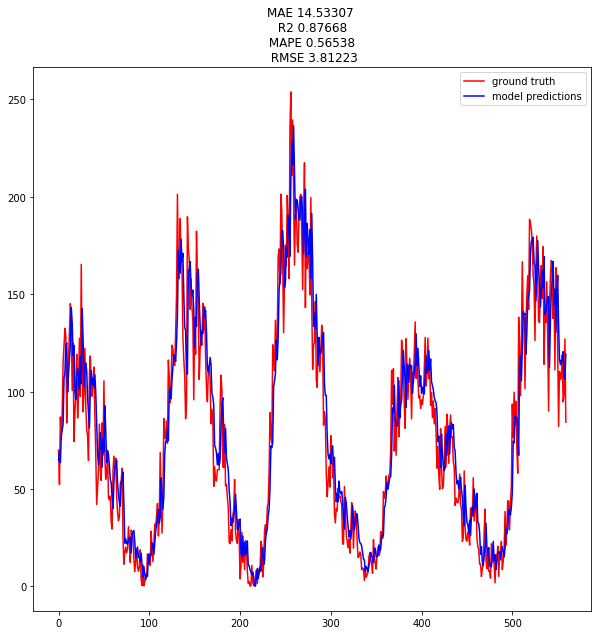

In [53]:
pred = model1.predict([past_test, fut_test], batch_size=32).reshape((-1,))*1.65
test = y_test.reshape((-1,))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## PETROLEUM WEEKLY PRICES DATASET

In [47]:
data = pd.DataFrame(pd.read_csv("petroleumWeeklyPrices.csv"))
data = data[data.columns[1]]

In [48]:
time_steps = 15
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [49]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past_train, fut_train, cur_train], y_train, epochs=10, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 7, 1)         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 7, 1)         0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 3, 256)       1536        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 3, 256)       1536        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_14 

Train on 1037 samples, validate on 260 samples
Epoch 1/10
1037/1037 [==============================] - 12s 11ms/step - loss: 0.4642 - mean_absolute_error: 0.7924 - val_loss: 0.7755 - val_mean_absolute_error: 1.2736
Epoch 2/10
1037/1037 [==============================] - 7s 7ms/step - loss: 0.0117 - mean_absolute_error: 0.1102 - val_loss: 0.9231 - val_mean_absolute_error: 1.4230
Epoch 3/10
1037/1037 [==============================] - 7s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0541 - val_loss: 0.9869 - val_mean_absolute_error: 1.4869
Epoch 4/10
1037/1037 [==============================] - 7s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0728 - val_loss: 0.9310 - val_mean_absolute_error: 1.4309
Epoch 5/10
1037/1037 [==============================] - 7s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0552 - val_loss: 0.9750 - val_mean_absolute_error: 1.4749
Epoch 6/10
1037/1037 [==============================] - 7s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0849 - val_lo

In [ ]:
fut_train1 = np.zeros_like(fut_train)
pred = model1.predict([past_train, fut_train1, cur_train], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model1.predict([past_test, fut_test, cur_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [13]:
lin_model.coef_

array([ 2.21173453], dtype=float32)

In [ ]:
print(pred1.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_absolute_error(test,pred1))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model pred1ictions')
plt.legend()
plt.show()

In [ ]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

# NYC LOAD DATA

In [22]:
nyc_data = pkl.load(open("data_for_NYC_seasons.pkl","rb"))
print ("Dropping column : ",nyc_data.columns[1])
nyc_data.drop(nyc_data.columns[1],axis=1,inplace=True)
nyc_data

Dropping column :  nan


,N.Y.C.,Week_number,dayofweek,Year,Month,Day,Hour,Weekends,Temperature,Humidity,DewPoint,FeelsLikeC,WindChillC,WindspeedKmph,cloudcover,Holidays,Seasons
0,4937.5,52.0,6.0,2012.0,1.0,1.0,0.0,1.0,6.0,93.0,5.0,3.0,3.0,16.0,40.0,0,2
1,4752.1,52.0,6.0,2012.0,1.0,1.0,1.0,1.0,5.0,95.0,4.0,2.0,2.0,13.0,60.0,0,2
2,4542.6,52.0,6.0,2012.0,1.0,1.0,2.0,1.0,4.0,97.0,4.0,2.0,2.0,10.0,80.0,0,2
3,4357.7,52.0,6.0,2012.0,1.0,1.0,3.0,1.0,3.0,99.0,3.0,1.0,1.0,7.0,100.0,0,2
4,4275.5,52.0,6.0,2012.0,1.0,1.0,4.0,1.0,3.0,99.0,3.0,1.0,1.0,6.0,100.0,0,2
5,4274.7,52.0,6.0,2012.0,1.0,1.0,5.0,1.0,2.0,99.0,2.0,0.0,0.0,6.0,100.0,0,2
6,4324.9,52.0,6.0,2012.0,1.0,1.0,6.0,1.0,1.0,100.0,1.0,0.0,0.0,5.0,100.0,0,2
7,4350.0,52.0,6.0,2012.0,1.0,1.0,7.0,1.0,2.0,98.0,1.0,0.0,0.0,6.0,90.0,0,2
8,4480.9,52.0,6.0,2012.0,1.0,1.0,8.0,1.0,2.0,96.0,1.0,0.0,0.0,6.0,79.0,0,2
9,4664.2,52.0,6.0,2012.0,1.0,1.0,9.0,1.0,2.0,94.0,1.0,0.0,0.0,7.0,69.0,0,2


In [23]:
data = pd.DataFrame(nyc_data.iloc[:,0]).iloc[-2000:,0]
data.columns = ["Load"]

In [24]:
data.reset_index(drop=True,inplace=True)
data = pd.DataFrame(data)
data.columns = ["Load"]
data

,Load
0,7724.5
1,7813.3
2,7786.3
3,7811.7
4,7644.6
5,7430.5
6,7139.6
7,6735.3
8,6263.1
9,5765.1


In [25]:
time_steps = 21
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [38]:
model1 = model_build1(past.shape[1:], fut.shape[1:])
model1.fit([past_train, fut_train], y_train, epochs=10, batch_size=32, validation_data=([past_test,fut_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 6, 256)       1536        input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 6, 256)       1536        input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_18 

Train on 1583 samples, validate on 396 samples
Epoch 1/10
1583/1583 [==============================] - 39s 25ms/step - loss: 2652.9558 - mean_absolute_error: 2653.4558 - val_loss: 3367.2386 - val_mean_absolute_error: 3367.7386
Epoch 2/10
1583/1583 [==============================] - 27s 17ms/step - loss: 803.6259 - mean_absolute_error: 804.1258 - val_loss: 2906.1616 - val_mean_absolute_error: 2906.6616
Epoch 3/10
1583/1583 [==============================] - 27s 17ms/step - loss: 649.3667 - mean_absolute_error: 649.8666 - val_loss: 3518.4355 - val_mean_absolute_error: 3518.9355
Epoch 4/10
1583/1583 [==============================] - 27s 17ms/step - loss: 725.1193 - mean_absolute_error: 725.6191 - val_loss: 3139.6616 - val_mean_absolute_error: 3140.1616
Epoch 5/10
1583/1583 [==============================] - 27s 17ms/step - loss: 357.9588 - mean_absolute_error: 358.4588 - val_loss: 3157.4811 - val_mean_absolute_error: 3157.9811
Epoch 6/10
1583/1583 [==============================] - 27s 1

In [45]:
pred = model1.predict([past_test, fut_test], batch_size=32) * 2.25
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

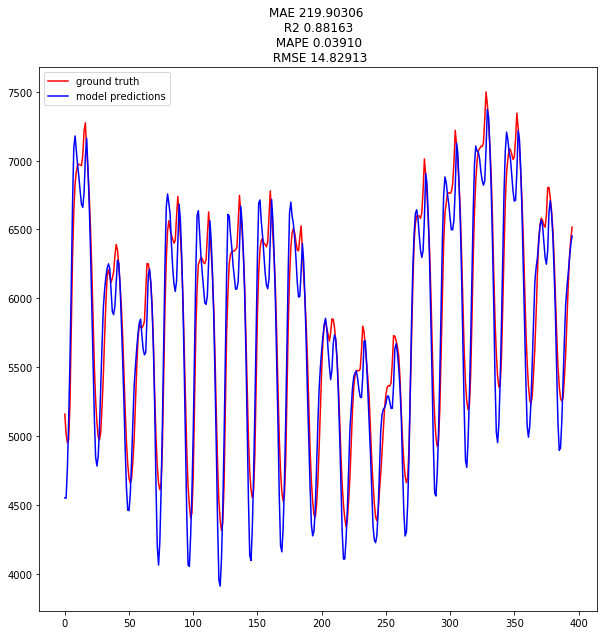

In [46]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

# SPI M+L model

## Variant 2

In [8]:
data = pd.DataFrame(pd.read_csv("../notNiteeshData.csv")['ES_POPCORN SMALL'])
print (data.shape)
data = data[data[data.columns[0]]!=0]
data = data[data[data.columns[0]]<=600]
data_train = data[:-100]
data_train.reset_index(drop=True,inplace=True)
data_test = data[-100:]
data_test.reset_index(drop=True,inplace=True)
print (data.shape,data_train.shape,data_test.shape)

(991, 1)
(899, 1) (799, 1) (100, 1)


In [9]:
time_steps = 15
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [10]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past_train, fut_train, cur_train], y_train, epochs=100, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7, 1)         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 3, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

Train on 707 samples, validate on 177 samples
Epoch 1/100
707/707 [==============================] - 8s 11ms/step - loss: 323.2816 - mean_absolute_error: 323.7815 - val_loss: 190.5570 - val_mean_absolute_error: 191.0570
Epoch 2/100
707/707 [==============================] - 5s 7ms/step - loss: 119.1035 - mean_absolute_error: 119.6026 - val_loss: 188.0288 - val_mean_absolute_error: 188.5288
Epoch 3/100
707/707 [==============================] - 5s 7ms/step - loss: 72.9083 - mean_absolute_error: 73.4061 - val_loss: 153.0052 - val_mean_absolute_error: 153.5052
Epoch 4/100
707/707 [==============================] - 5s 7ms/step - loss: 69.1043 - mean_absolute_error: 69.6024 - val_loss: 168.9059 - val_mean_absolute_error: 169.4059
Epoch 5/100
707/707 [==============================] - 5s 7ms/step - loss: 62.2724 - mean_absolute_error: 62.7720 - val_loss: 164.7704 - val_mean_absolute_error: 165.2704
Epoch 6/100
707/707 [==============================] - 5s 7ms/step - loss: 64.6549 - mean_abso

Epoch 96/100
707/707 [==============================] - 5s 7ms/step - loss: 52.6489 - mean_absolute_error: 53.1459 - val_loss: 143.2510 - val_mean_absolute_error: 143.7510
Epoch 97/100
707/707 [==============================] - 5s 7ms/step - loss: 43.5434 - mean_absolute_error: 44.0426 - val_loss: 155.5266 - val_mean_absolute_error: 156.0266
Epoch 98/100
707/707 [==============================] - 5s 7ms/step - loss: 53.4542 - mean_absolute_error: 53.9530 - val_loss: 161.5708 - val_mean_absolute_error: 162.0708
Epoch 99/100
707/707 [==============================] - 5s 7ms/step - loss: 52.3237 - mean_absolute_error: 52.8216 - val_loss: 128.9938 - val_mean_absolute_error: 129.4938
Epoch 100/100
707/707 [==============================] - 5s 7ms/step - loss: 52.0950 - mean_absolute_error: 52.5922 - val_loss: 113.1167 - val_mean_absolute_error: 113.6167


In [51]:
fut_train1 = np.zeros_like(fut_train)
pred = model1.predict([past_train,fut_train1,cur_train]).reshape(-1,1)

In [52]:
#Build a Linear Regression for the predictions to Final Value.
#TRAINING THE LINEAR REGRESSOR.
from sklearn import linear_model
linreg_data = pd.DataFrame(pred,columns=["Bi Pred"])
linreg_test = pd.DataFrame(y_train,columns=["Bi Test"])
print (linreg_data.shape , linreg_test.shape)
split = int(0.7*(linreg_data.shape[0]))

linreg_train_data = linreg_data.values[:split]
linreg_train_test = linreg_test.values[:split]

linreg_test_data = linreg_data.values[split:]
linreg_test_test = linreg_test.values[split:]

lin_model = linear_model.LinearRegression()
lin_model.fit(linreg_train_data,linreg_train_test)
lin_pred = lin_model.predict(linreg_test_data)

(2239, 1) (2239, 1)


In [55]:
test.shape , pred.shape

((560,), (2239, 1))

In [46]:
lin_pred[linreg_test_test != 0].shape , linreg_test_data[linreg_test_test != 0].shape

((665,), (665,))

(672, 1) (672, 1)


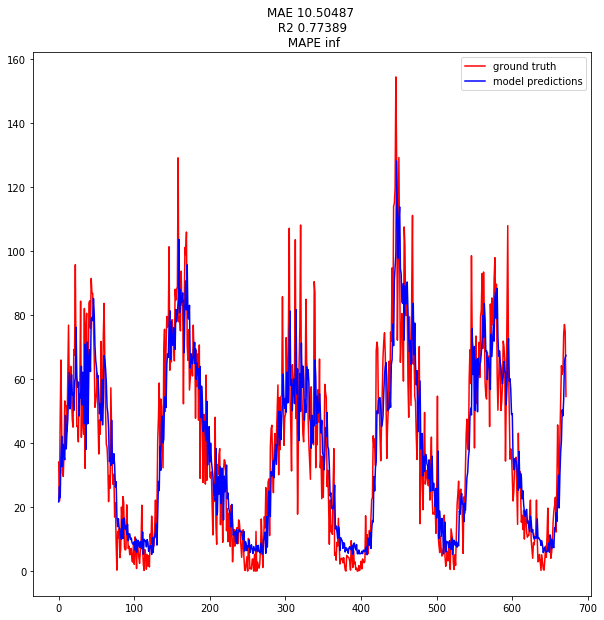

In [40]:
print(lin_pred.shape, linreg_test_test.shape)
from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title(" LINEAR REGRESSOR ")

#lin_pred = lin_pred[linreg_test_test != 0]
#linreg_test_test = linreg_test_test[linreg_test_test != 0]

plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(linreg_test_test,lin_pred), r2_score(linreg_test_test,lin_pred), np.mean(np.abs(linreg_test_test-lin_pred)/linreg_test_test)))
plt.plot(linreg_test_test, color='r', label='ground truth')
plt.plot(lin_pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [36]:
lin_model.coef_

array([[ 1.72218299]], dtype=float32)

(560,) (560,)


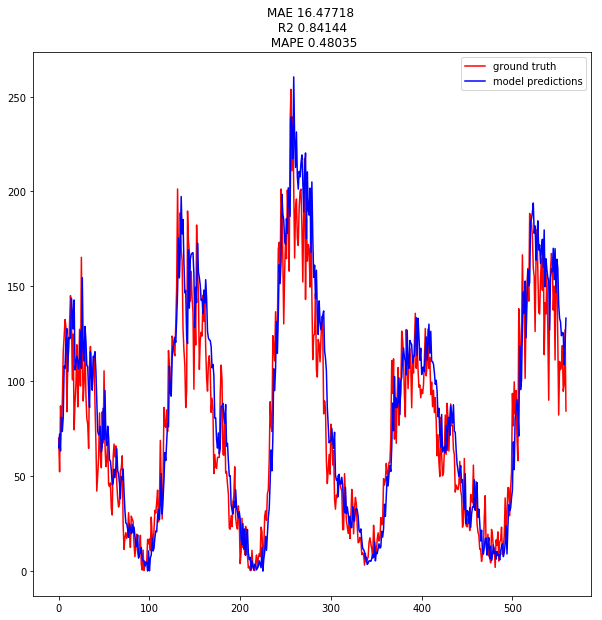

In [29]:
#Now, testing on the unseen part of the data, with this pipeline in place.
#Just the Bi- CNN LSTM DNN 's prediction.

pred = model1.predict([past_test,fut_test,cur_test])
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))
const = 2
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title(" Bi-CNN LSTM DNN TESTING !!")
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(test,pred*const), r2_score(test,pred*const), np.mean(np.abs(test-pred*const)/test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred * const, color='b', label='model predictions')
plt.legend()
plt.show()

(560,) (560,)


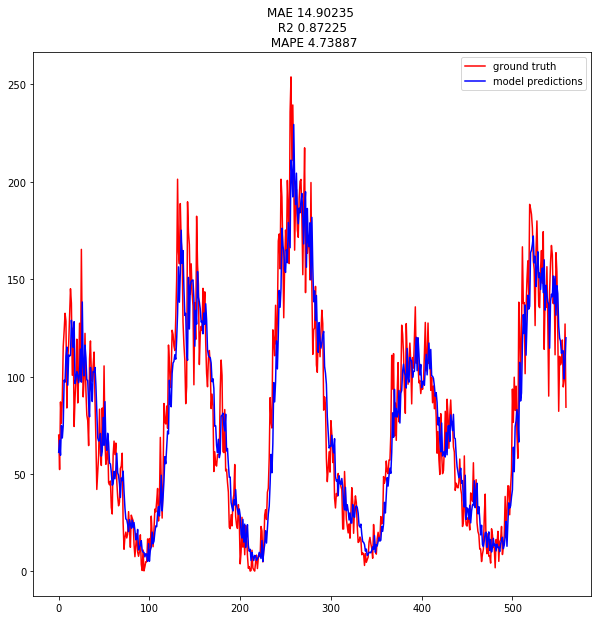

In [28]:
#Prediction augmented by the linear regressor.
lin_test_pred = lin_model.predict(pred.reshape(-1,1))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title(" Bi-CNN LSTM DNN followed by a LINEAR REGRESSOR TESTING !!")
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(test,lin_test_pred), r2_score(test,lin_test_pred), np.mean(np.abs(test-lin_test_pred)/test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(lin_test_pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [79]:
time_steps = 15
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [114]:
#Test part will be the 'train period of the Linear Regressor'.
lin_model = linear_model.LinearRegression()
lin_model.fit(m_past_test[:,int(time_steps/2)-1,:],l_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
pred = model1.predict([past_test,fut_test,cur_test])
lin_pred = lin_model.predict(pred)

In [116]:
y_test.shape , pred.shape

((177,), (177, 1))

(177, 1) (177, 1)


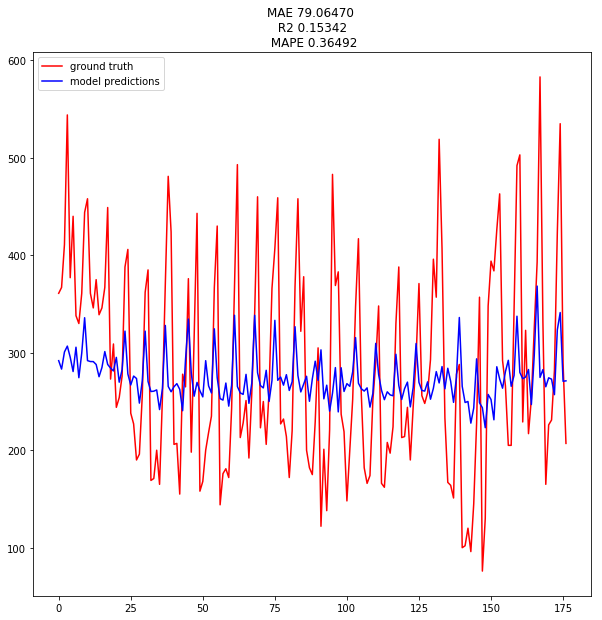

In [117]:
#Prediction augmented by the linear regressor.
test = y_test.reshape((-1,1))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title(" Bi-CNN LSTM DNN followed by a LINEAR REGRESSOR TESTING !!")
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(test,lin_pred), r2_score(test,lin_pred), np.mean(np.abs(test-lin_pred)/test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(lin_pred, color='b', label='model predictions')
plt.legend()
plt.show()